##### Input Data -
Reviews and their labels (sentiments)
##### Output -
Model for predicting sentiment class
##### Notes -
I am using a feed forward 1 hidden layer net

###### Task 1 - Gathering the features

In [350]:
#Keeping it simple word count only as features.
import numpy as np

def get_sent_word_count(sample_file):
    file_as_lines =[]
    sentiments = []
    index = 0
    word_count = {}

    for line in sample_file:
        line = line.strip()
        sentiments.append(int(line[-1]))
        line = line[:-1].strip()
        chars_to_avoid = '-:,;[({})]!?'
        for word in line.split():
            if word not in word_count:
                word = word.lower()
                #remove punctuations in word
                for c in chars_to_avoid:
                    word = word.replace(c, '')
                word_count[word] = [(index, 1)]
            else:
                prev_index, count = word_count[word][-1]
                if prev_index == index:
                    count += 1
                    word_count[word][-1] = (index, count)
                else:
                    count = 1
                    word_count[word].append((index, count))

        index += 1
    
    #print word_count, sentiments
    
    return sentiments, word_count

In [351]:
### Now forming the input vectors from word_count

def get_wcm(word_count, ninputs):
    ## feature_count - no of words
    ## inputs - file count
    features = word_count.keys()
    # print features
    nfeatures = len(features)
    #ninputs = index
    word_count_matrix = np.zeros((ninputs, nfeatures))

    for wcm_col, feature in enumerate(features):
        row_col_list = word_count[feature]
    #     print row_col_list
        for wcm_row, wcm_val in row_col_list:
            word_count_matrix[wcm_row][wcm_col] = wcm_val
    
    return word_count_matrix

def load_data(filename):
    sentiments, word_count = get_sent_word_count(filename)
    #get word_count matrix
    wcm = get_wcm(word_count, len(sentiments))
    sentiments = np.asarray(sentiments)
    data = wcm
    data[:, 0] = sentiments
    return data

sample_file = open("sample.txt", "r")
data = load_data(sample_file)
sample_file.close()
# print data[:,0]
# print data[:,1:]

##### Task2 - Forming the NN

In [352]:
## Making a  Feed forward NN model

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def dsigmoid(y):
    return y * (1.0 - y)

In [363]:
class MLP_NeuralNetwork(object):
    
    def __init__(self, input, hidden, output, iterations = 50,\
                 learning_rate = 0.02):
        
        self.input = input + 1 # add 1 for bias node
        self.hidden = hidden
        self.output = output
        self.iterations = iterations
        self.learning_rate = learning_rate
        
        # set up array of 1s for activations
        self.ai = [1.0] * self.input
        self.ah = [1.0] * self.hidden
        self.ao = [1.0] * self.output
        # create randomized weights
        self.wi = np.random.randn(self.input, self.hidden) 
        self.wo = np.random.randn(self.hidden, self.output) 
        # create arrays of 0 for changes
        #self.ci = np.zeros((self.input, self.hidden))
        #self.co = np.zeros((self.hidden, self.output))

        
    def feedForward(self, inputs):
       
        assert(len(inputs) == self.input-1)
        
        # input activations
        for i in range(self.input -1): # -1 is to avoid the bias
            self.ai[i] = inputs[i]
        # hidden activations
        for j in range(self.hidden):
            sum = 0.0
            for i in range(self.input):
                sum += self.ai[i] * self.wi[i][j]
            self.ah[j] = sigmoid(sum)
        # output activations
        for k in range(self.output):
            sum = 0.0
            for j in range(self.hidden):
                sum += self.ah[j] * self.wo[j][k]
            self.ao[k] = sigmoid(sum)
        return self.ao[:]
    
    
    def backPropagate(self, targets, N):
        
        assert(len(targets) == self.output)
        
        # calculate error terms for output
        # the delta tell you which direction to change the weights
        output_deltas = [0.0] * self.output
        for k in range(self.output):
            error = -(targets[k] - self.ao[k])
            output_deltas[k] = dsigmoid(self.ao[k]) * error
        
        # calculate error terms for hidden
        # delta tells you which direction to change the weights
        hidden_deltas =  [0.0] * self.hidden
        for j in range(self.hidden):
            error = 0.0
            for k in range(self.output):
                error += output_deltas[k] * self.wo[j][k]
            hidden_deltas[j] = dsigmoid(self.ah[j]) * error
        
        # update the weights hidden-output
        for j in range(self.hidden):
            for k in range(self.output):
                change = output_deltas[k] * self.ah[j]
                self.wo[j][k] -= N * change #+ self.co[j][k]
                #self.co[j][k] = change
        
        # update the weights input-hidden
        for i in range(self.input):
            for j in range(self.hidden):
                change = hidden_deltas[j] * self.ai[i]
                self.wi[i][j] -= N * change #+ self.ci[i][j]
                #self.ci[i][j] = change
        
        # calculate error
        error = 0.0
        for k in range(len(targets)):
            error += 0.5 * (targets[k] - self.ao[k]) ** 2
        return error
    
    
    ##Now we go for train and predict
    def train(self, patterns, logs=False):
        # N: learning rate
        itercount = 0
        for i in range(self.iterations):
            
            if logs:
                print "Iteration - {}".format(i)
            error, prev_error = 0.0, 0.0
            for p in patterns:
                inputs = p[1:]
                targets = p[0]
                self.feedForward(inputs)
                error = self.backPropagate([targets],\
                                           self.learning_rate)
                        
            ## print the error at every 10th iteration
            ## also stop if the error value is too less or its not converging
            if i % 10 == 0:
                delta = abs(error - prev_error)
                if delta < 0.000005 or error <= 0.0005:
                    break
                prev_error = error
                print('error %-.5f' % error)
            
            itercount += 1
        
        print "Total iterations- {}".format(itercount)
        
        return
    
    
    ## Just to get some output and calc precision/recall
    def test(self, patterns, logs=False):
        ## target val vs predicted val
        tot = len(patterns)
        tp, tn, fp, fn = 0, 0, 0, 0
        for p in patterns:
            pred = self.feedForward(p[1:])
            res = 1 if pred[0] >= 0.5 else 0
            if logs:
                print "{} -> {}".format(p[0], res)
            if p[0] == res:
                if p[0] == 1:
                    tp += 1
                else:
                    tn += 1
            else:
                if p[0] == 1:
                    fn += 1
                else:
                    fp += 1
        precision =  float(tp)/float(tp+fp)
        recall = float(tp)/float(tp+fn)
        fscore = float(2*precision*recall)/float(precision+recall)
        if logs:
            print "precision - {}".format(precision)
            print "recall - {}".format(recall)
            print "F1 score - {}".format(fscore)
        
        return (precision, recall, fscore)


In [361]:
def test_NN(nfeatures, X_train, X_test, iteration=50, neurons=10, learning_rate=0.02):
    # Actual feautres is 1 less
    NN = MLP_NeuralNetwork(nfeatures-1, neurons, 1, iteration, learning_rate)
    print "Begin training!!"
    NN.train(X_train, False)
    print "Done with training! Begin Tests!"
    p, r, f = NN.test(X_test, False)
    print "Test done!!"
    
    return p, r, f


##Now we test the above NN
## Load the data
sample_file = open("yelp_labelled.txt", "r")
X = load_data(sample_file)
print "data loaded!!"
sample_file.close()

ninputs, nfeatures = X.shape
print nfeatures
print ninputs

X_test = X[:int(0.2*ninputs)]
X_train = X[int(0.2*ninputs):]

##Uncomment below to have an individual test
#test_NN(nfeatures, X_train, X_test)



data loaded!!
2424
1000


##### Task 3 - Lets make a plots of these

In [368]:

# How does changing training iterations affect?
   
iterations = [50, 100, 200, 500]
neurons = [5, 10, 20, 50]


precisions = []
recalls = []
fscores = []

#keep number of neurons to be 10
for iteration in iterations:
    print "Begin training iteration- {}".format(iteration)
    prec, rec, fscr = test_NN(nfeatures, X_train, X_test, iteration, 10, 0.02)
    precisions.append(prec)
    recalls.append(rec)
    fscores.append(fscr)
    print "Done with iteration -{}".format(iteration)



Begin training iteration- 50
Begin training!!
error 0.37151
error 0.04308
error 0.03913
error 0.03786
error 0.03588
Total iterations- 50
Done with training! Begin Tests!
Test done!!
Done with iteration -50
Begin training iteration- 100
Begin training!!
Total iterations- 0
Done with training! Begin Tests!
Test done!!
Done with iteration -100
Begin training iteration- 200
Begin training!!
error 0.01497
error 0.01571
error 0.01592
error 0.01473
error 0.01285
error 0.01080
error 0.00883
error 0.00707
error 0.00556
error 0.00429
error 0.00327
error 0.00246
error 0.00183
error 0.00135
error 0.00099
error 0.00072
error 0.00052
Total iterations- 170
Done with training! Begin Tests!
Test done!!
Done with iteration -200
Begin training iteration- 500
Begin training!!
error 0.21165
error 0.12792
error 0.08130
error 0.06822
error 0.06276
error 0.05896
error 0.05534
error 0.05157
error 0.04763
error 0.04361
error 0.03957
error 0.03560
error 0.03176
error 0.02811
error 0.02469
error 0.02154
error 0.0

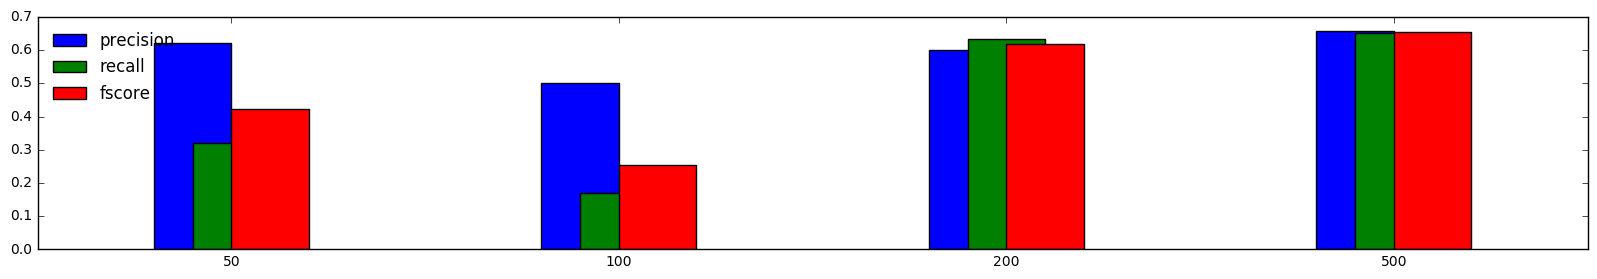

In [407]:
import matplotlib.pyplot as plt
iterations = [10, 20, 30, 40]
iterations = np.asarray(iterations)
## Uncomment below to share the values for precision, recall etc
# print iterations
# print recalls
# print precisions
# print fscores
plt.bar(iterations-1, np.asarray(precisions),width=2, color='b',align='center', label='precision')
plt.bar(iterations, np.asarray(recalls), width=2, color='g',align='center', label='recall')
plt.bar(iterations+1, np.asarray(fscores), width=2,color='r',align='center', label='fscore')
plt.xticks(iterations, ['50', '100', '200', '500'])
plt.legend(loc='upper left', frameon=False)
plt.show()

